# Init

In [7]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader
from datasets import load_dataset
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [4]:
def sentence_pairs_generation(sentences, labels, pairs):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if a pair is positive or negative

  numClassesList = np.unique(labels)
  idx = [np.where(labels == i)[0] for i in numClassesList]

  for idxA in range(len(sentences)):
    currentSentence = sentences[idxA]
    label = labels[idxA]
    idxB = np.random.choice(idx[np.where(numClassesList==label)[0][0]])
    posSentence = sentences[idxB]
		  # prepare a positive pair and update the sentences and labels
		  # lists, respectively
    pairs.append(InputExample(texts=[currentSentence, posSentence], label=1.0))

    negIdx = np.where(labels != label)[0]
    negSentence = sentences[np.random.choice(negIdx)]
		  # prepare a negative pair of images and update our lists
    pairs.append(InputExample(texts=[currentSentence, negSentence], label=0.0))

	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [3]:
#SST-2
# Load SST-2 dataset into a pandas dataframe.

train_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

# Load the test dataset into a pandas dataframe.
eval_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/test.tsv', delimiter='\t', header=None)

text_col=train_df.columns.values[0]
category_col=train_df.columns.values[1]

x_eval = eval_df[text_col].values.tolist()
y_eval = eval_df[category_col].values.tolist()

# SetFit

In [5]:
#@title SetFit
st_model = 'paraphrase-mpnet-base-v2' #@param ['paraphrase-mpnet-base-v2', 'all-mpnet-base-v1', 'all-mpnet-base-v2', 'stsb-mpnet-base-v2', 'all-MiniLM-L12-v2', 'paraphrase-albert-small-v2', 'all-roberta-large-v1']
num_training = 32 #@param ["8", "16", "32", "54", "128", "256", "512"] {type:"raw"}
num_itr = 5 #@param ["1", "2", "3", "4", "5", "10"] {type:"raw"}
plot2d_checkbox = False #@param {type: 'boolean'}

set_seed(0)
# Equal samples per class training
train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train = train_df_sample[text_col].values.tolist()
y_train = train_df_sample[category_col].values.tolist()

train_examples = []
for x in range(num_itr):
  train_examples = sentence_pairs_generation(np.array(x_train), np.array(y_train), train_examples)

orig_model = SentenceTransformer(st_model)
model = SentenceTransformer(st_model)

# S-BERT adaptation - finetuning the ST model:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=10, show_progress_bar=True)

# No Fit, using the ST model out of the box to encode sentences:
X_train_noFT = orig_model.encode(x_train)
X_eval_noFT = orig_model.encode(x_eval)
# then train the classification head:
sgd =  LogisticRegression()
sgd.fit(X_train_noFT, y_train)
y_pred_eval_sgd = sgd.predict(X_eval_noFT)

print('Acc. No Fit', accuracy_score(y_eval, y_pred_eval_sgd))

# With Fit (SetFit), using the finetuned ST model to encode sentences:
X_train = model.encode(x_train)
X_eval = model.encode(x_eval)
# then train the classification head:
sgd =  LogisticRegression()
sgd.fit(X_train, y_train)
y_pred_eval_sgd = sgd.predict(X_eval)

print('Acc. SetFit', accuracy_score(y_eval, y_pred_eval_sgd))


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Acc. No Fit 0.8390993959362988
Acc. SetFit 0.9110378912685337


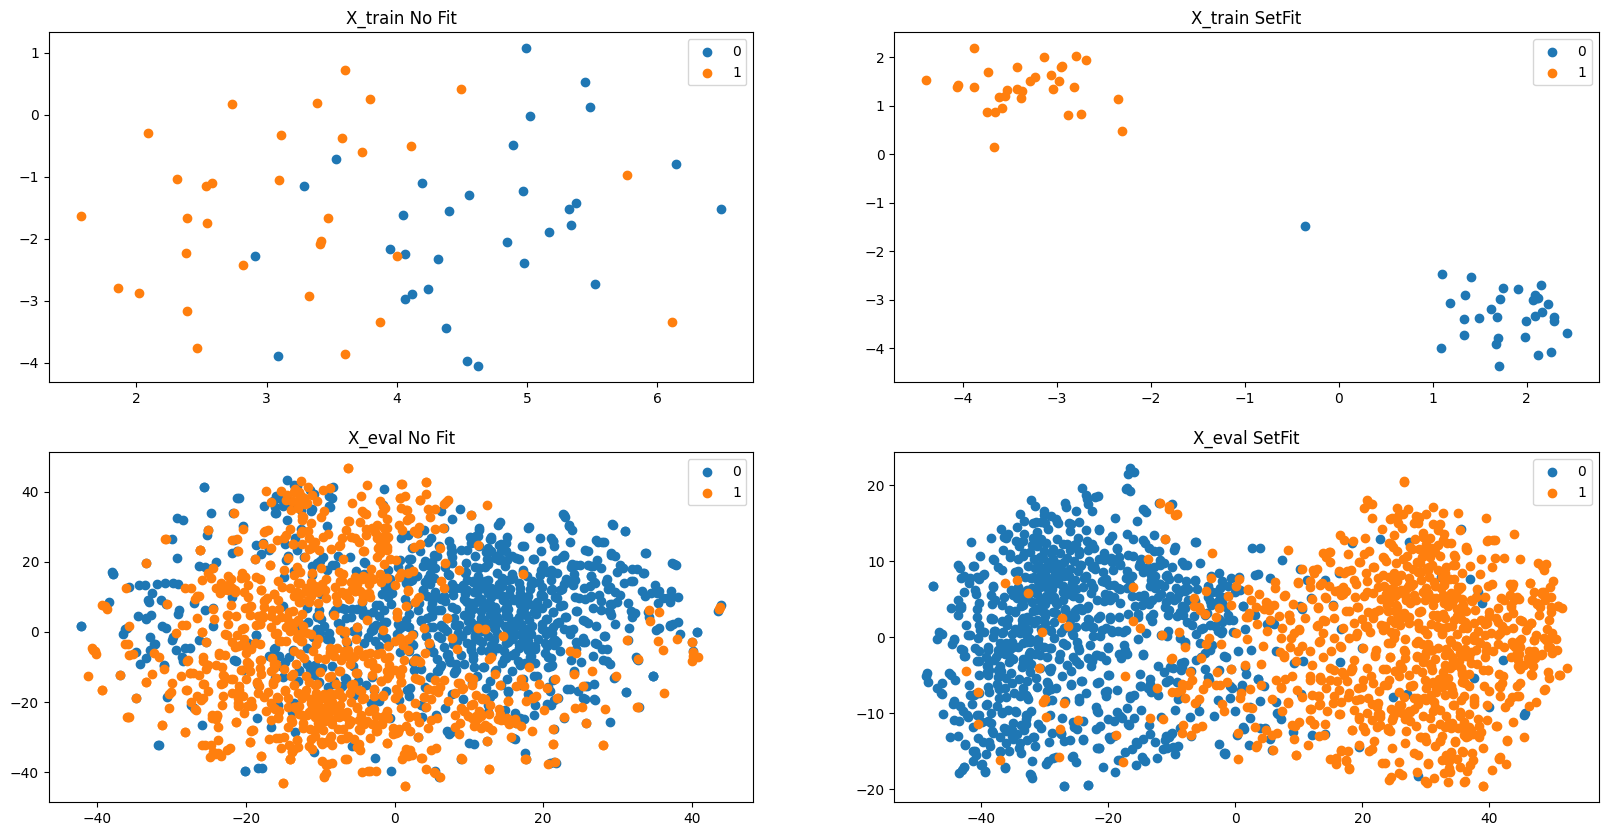

In [6]:
#Plot 2-D 2x2 figures
# if plot2d_checkbox:

plt.figure(figsize=(20,10))

#Plot X_train_noFit, which is the training set embeddings produced by the pretrained ST model
X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train_noFT))
plt.subplot(221)
plt.title('X_train No Fit')

for i, t in enumerate(set(np.array(y_train))):
    idx = np.array(y_train) == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)

plt.legend(bbox_to_anchor=(1, 1));

#Plot X_eval noFit, which is the validation set embeddings produced by the pretrained ST model
X_embedded = TSNE(n_components=2).fit_transform(np.array(X_eval_noFT))
plt.subplot(223)
plt.title('X_eval No Fit')

for i, t in enumerate(set(np.array(y_eval))):
    idx = np.array(y_eval) == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)

plt.legend(bbox_to_anchor=(1, 1));


#Plot X_train SetFit, which is the training embeddings produced by the finetuned ST model
X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train))

plt.subplot(222)
plt.title('X_train SetFit')

for i, t in enumerate(set(np.array(y_train))):
    idx = np.array(y_train) == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)

plt.legend(bbox_to_anchor=(1, 1));

#Plot X_eval SetFit, which is the validation embeddings produced by the finetuned ST model
X_embedded = TSNE(n_components=2).fit_transform(np.array(X_eval))
plt.subplot(224)
plt.title('X_eval SetFit')

for i, t in enumerate(set(np.array(y_eval))):
    idx = np.array(y_eval) == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)

plt.legend(bbox_to_anchor=(1, 1));